In [82]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os


from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif


In [52]:
load_dotenv()
BUCKET_NAME = os.getenv('BUCKET_NAME')
REGION = os.getenv('REGION')
DATA_FILE_PATH = os.getenv('DATA_FILE_PATH')
SERVICE = os.getenv('SERVICE')
SK_PREFIX_TRAIN= os.getenv("SK_PREFIX_TRAIN")
SK_PREFIX_TEST = os.getenv("SK_PREFIX_TEST")

# Constants

In [45]:
sm_boto3 = boto3.client(SERVICE)
sess = sagemaker.Session()
region = sess.boto_region_name
print(f"USING BUCKET: {BUCKET_NAME}")

USING BUCKET: sagemaker-ml-project-v1


In [46]:
df = pd.read_csv(DATA_FILE_PATH)
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


<AxesSubplot:xlabel='price', ylabel='Counts'>

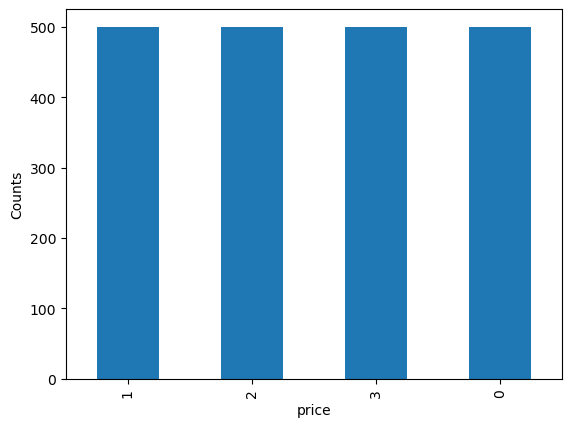

In [33]:
df['price_range'].value_counts().plot.bar(xlabel="price", ylabel="Counts")

In [34]:
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [35]:
df.duplicated().sum()

0

In [36]:
df.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

In [19]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


# Visuals

<AxesSubplot:>

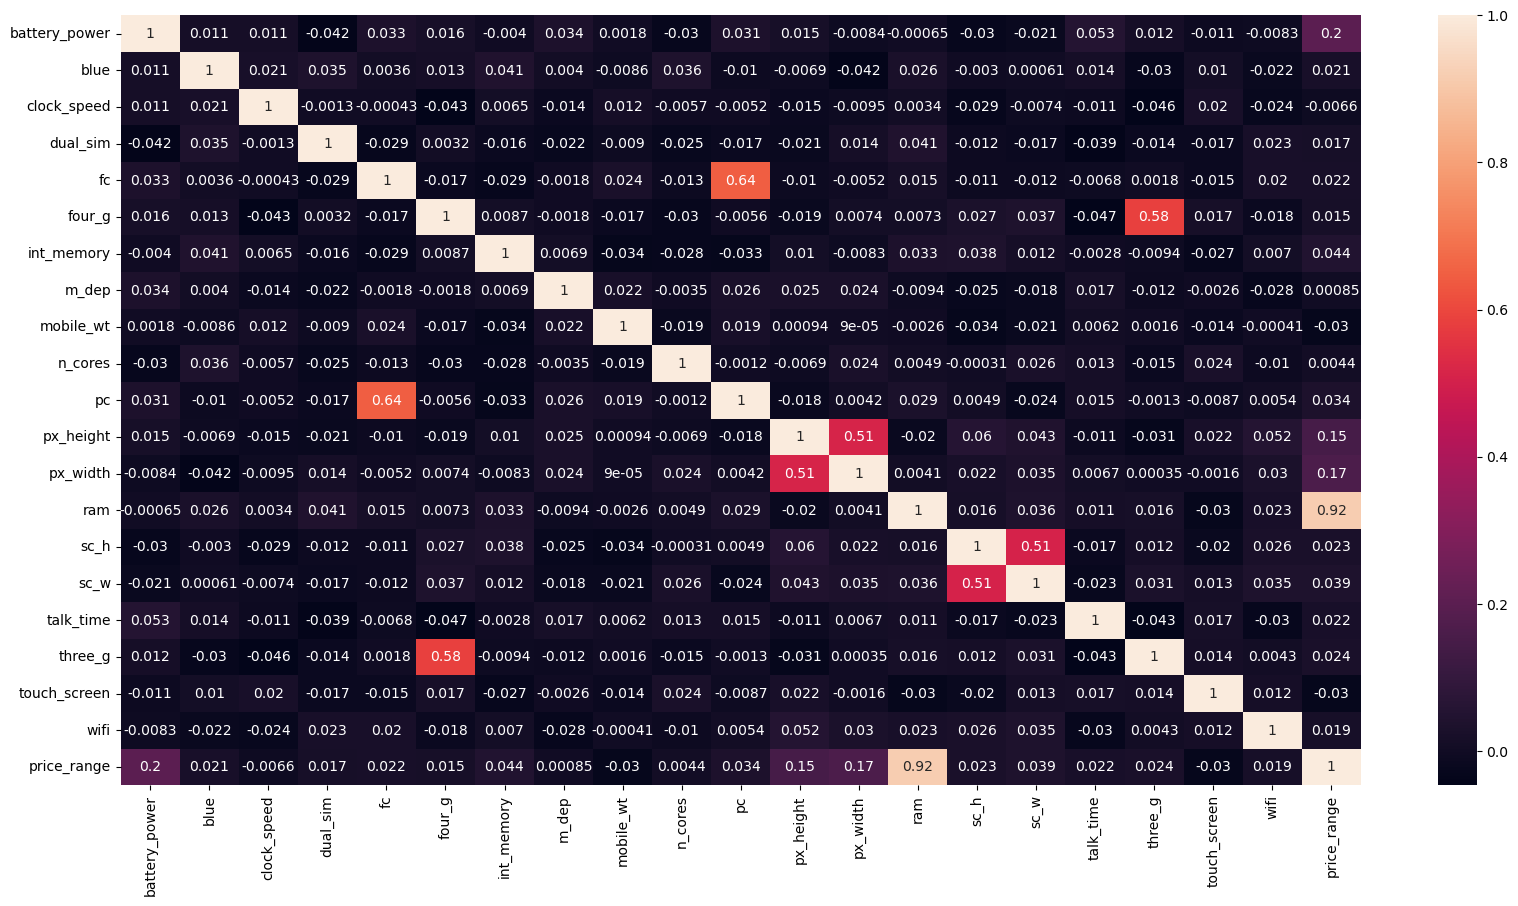

In [58]:
plt.figure(figsize=(20, 10))
relations = df.corr()
sns.heatmap(data=relations, annot=True)

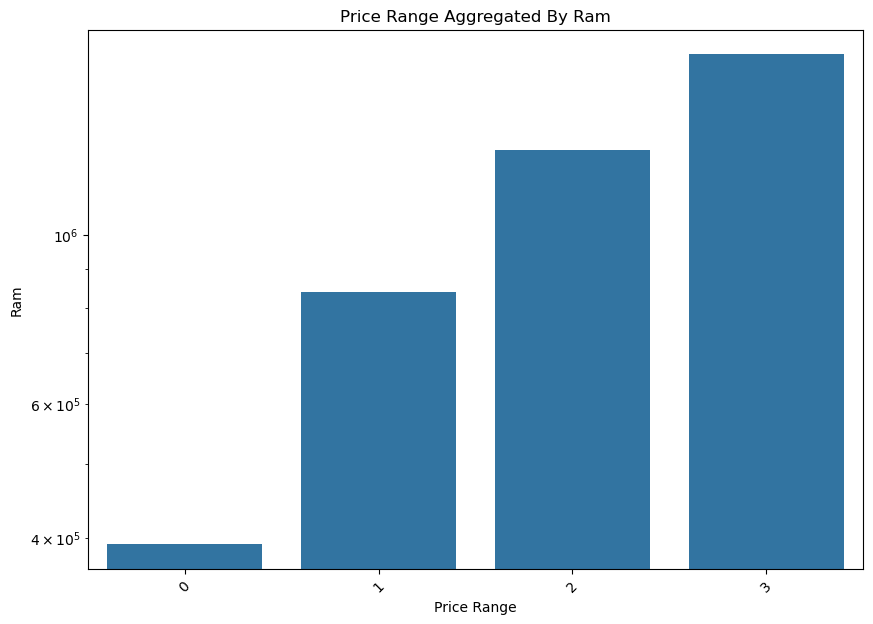

In [63]:
plt.figure(figsize=(10, 7))

grouped_df = df.groupby("price_range")["ram"].sum().reset_index()
sns.barplot(data=grouped_df, x="price_range", y="ram")

plt.title("Price Range Aggregated By Ram")
plt.xlabel("Price Range")
plt.yscale("log")
plt.ylabel("Ram")
plt.xticks(rotation=45)
plt.show()

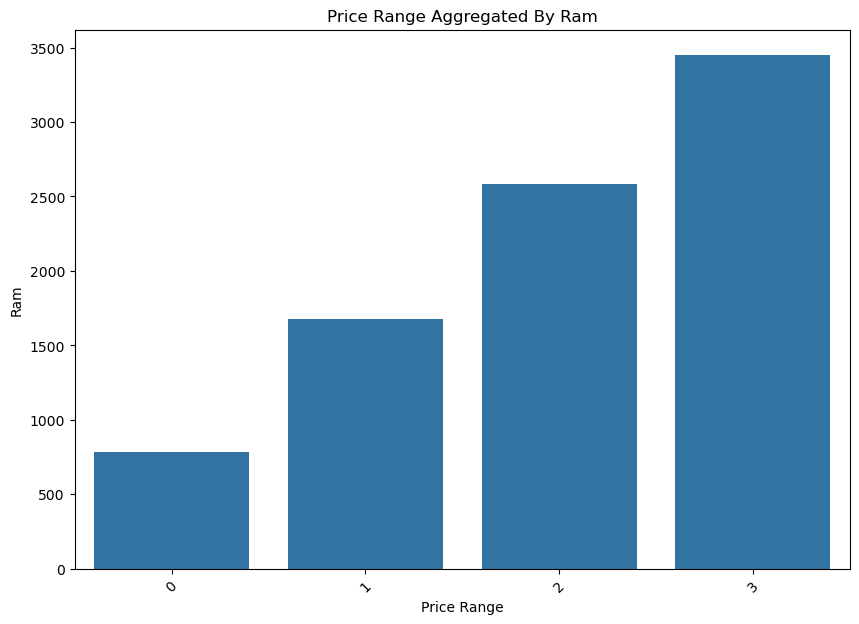

In [62]:
plt.figure(figsize=(10, 7))

grouped_df = df.groupby("price_range")["ram"].mean().reset_index()
sns.barplot(data=grouped_df, x="price_range", y="ram")

plt.title("Price Range Aggregated By Ram")
plt.xlabel("Price Range")
plt.ylabel("Ram")
plt.xticks(rotation=45)
plt.show()

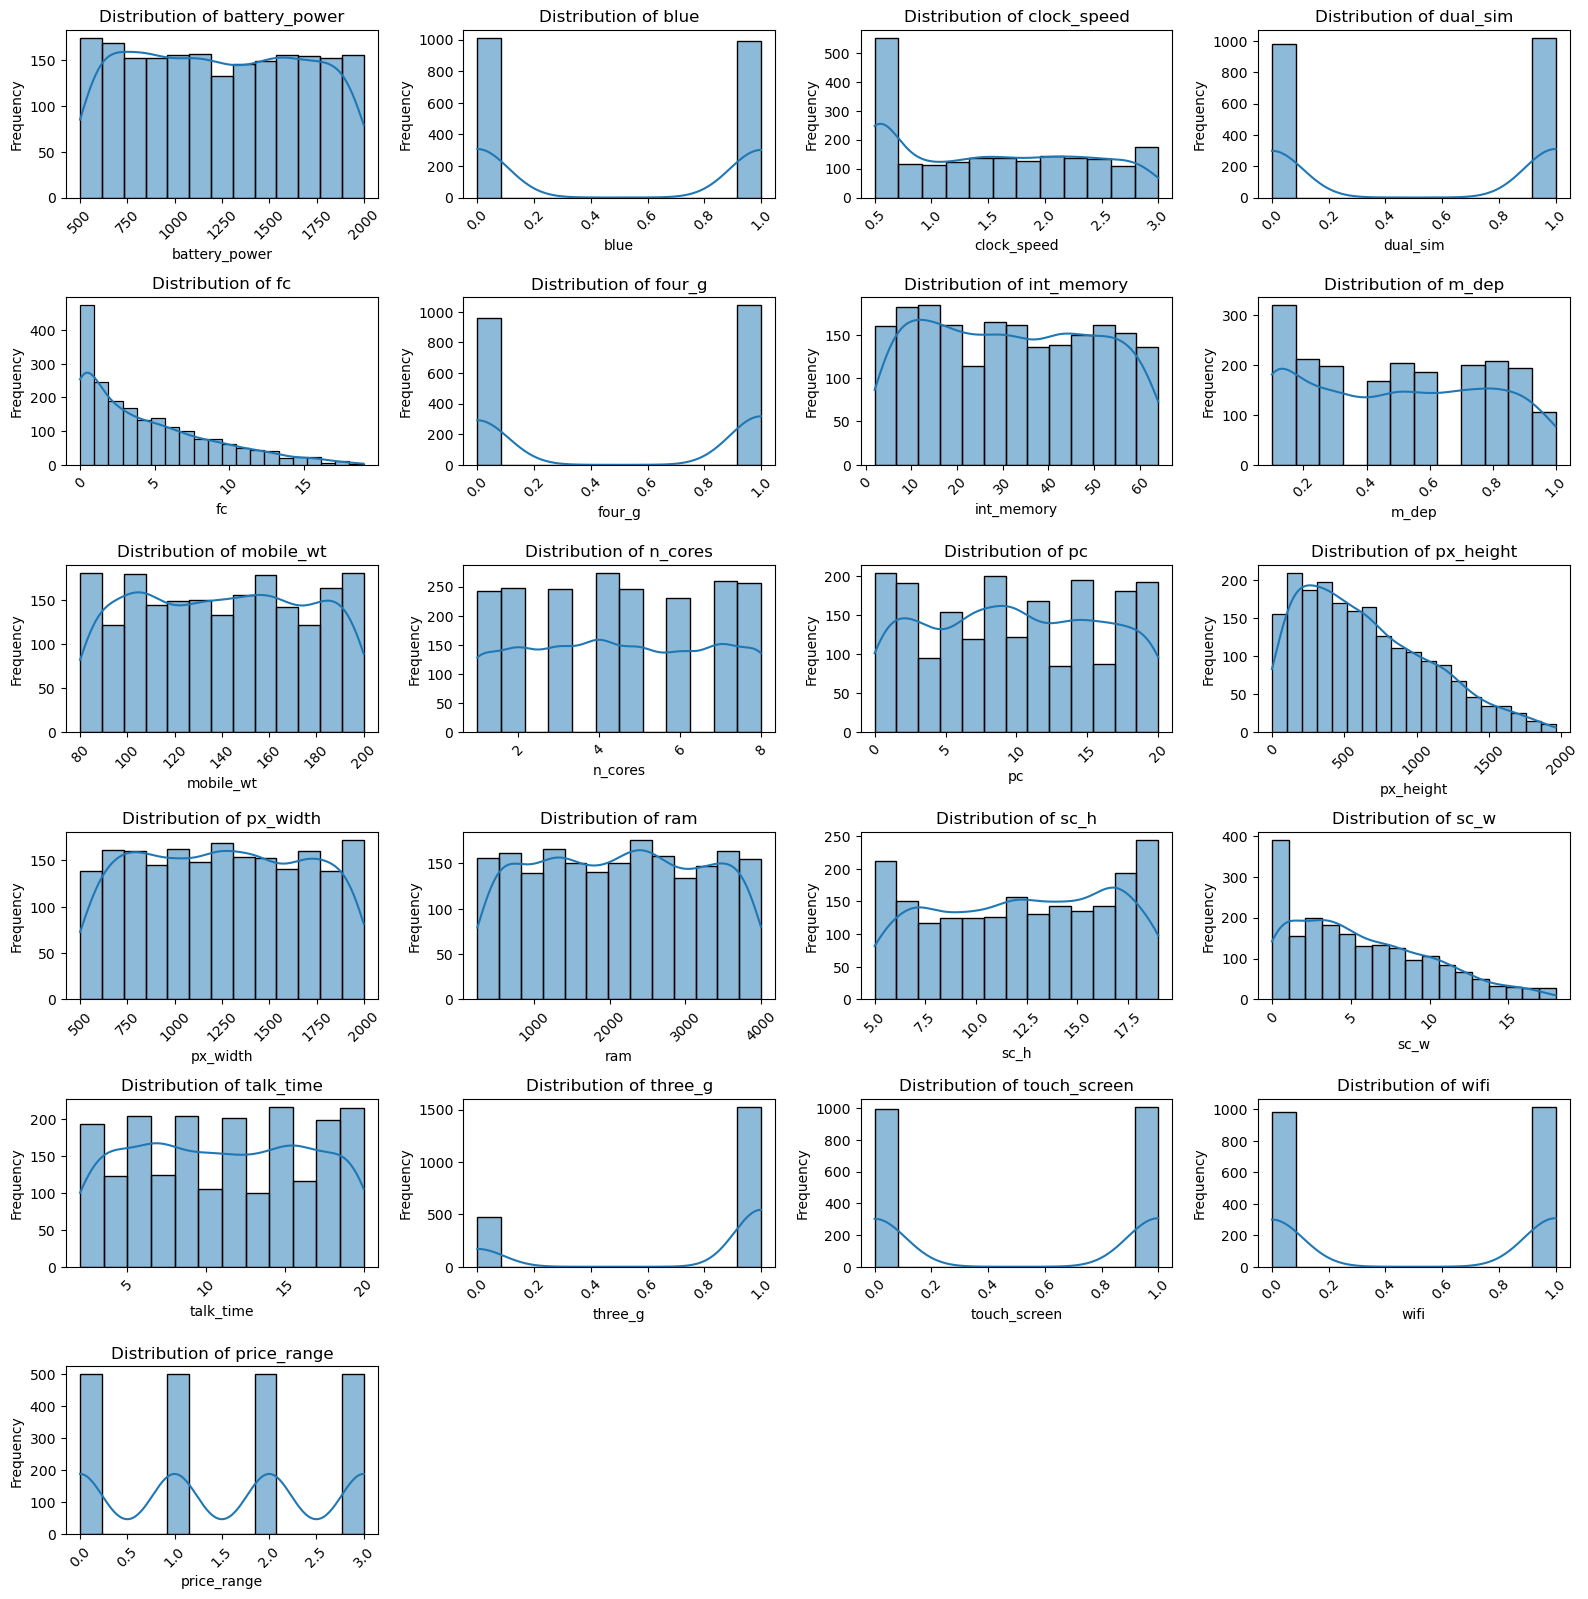

In [66]:
rows = len(df.columns)
dims = (rows+3)//4
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df.columns):
  plt.subplot(dims, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

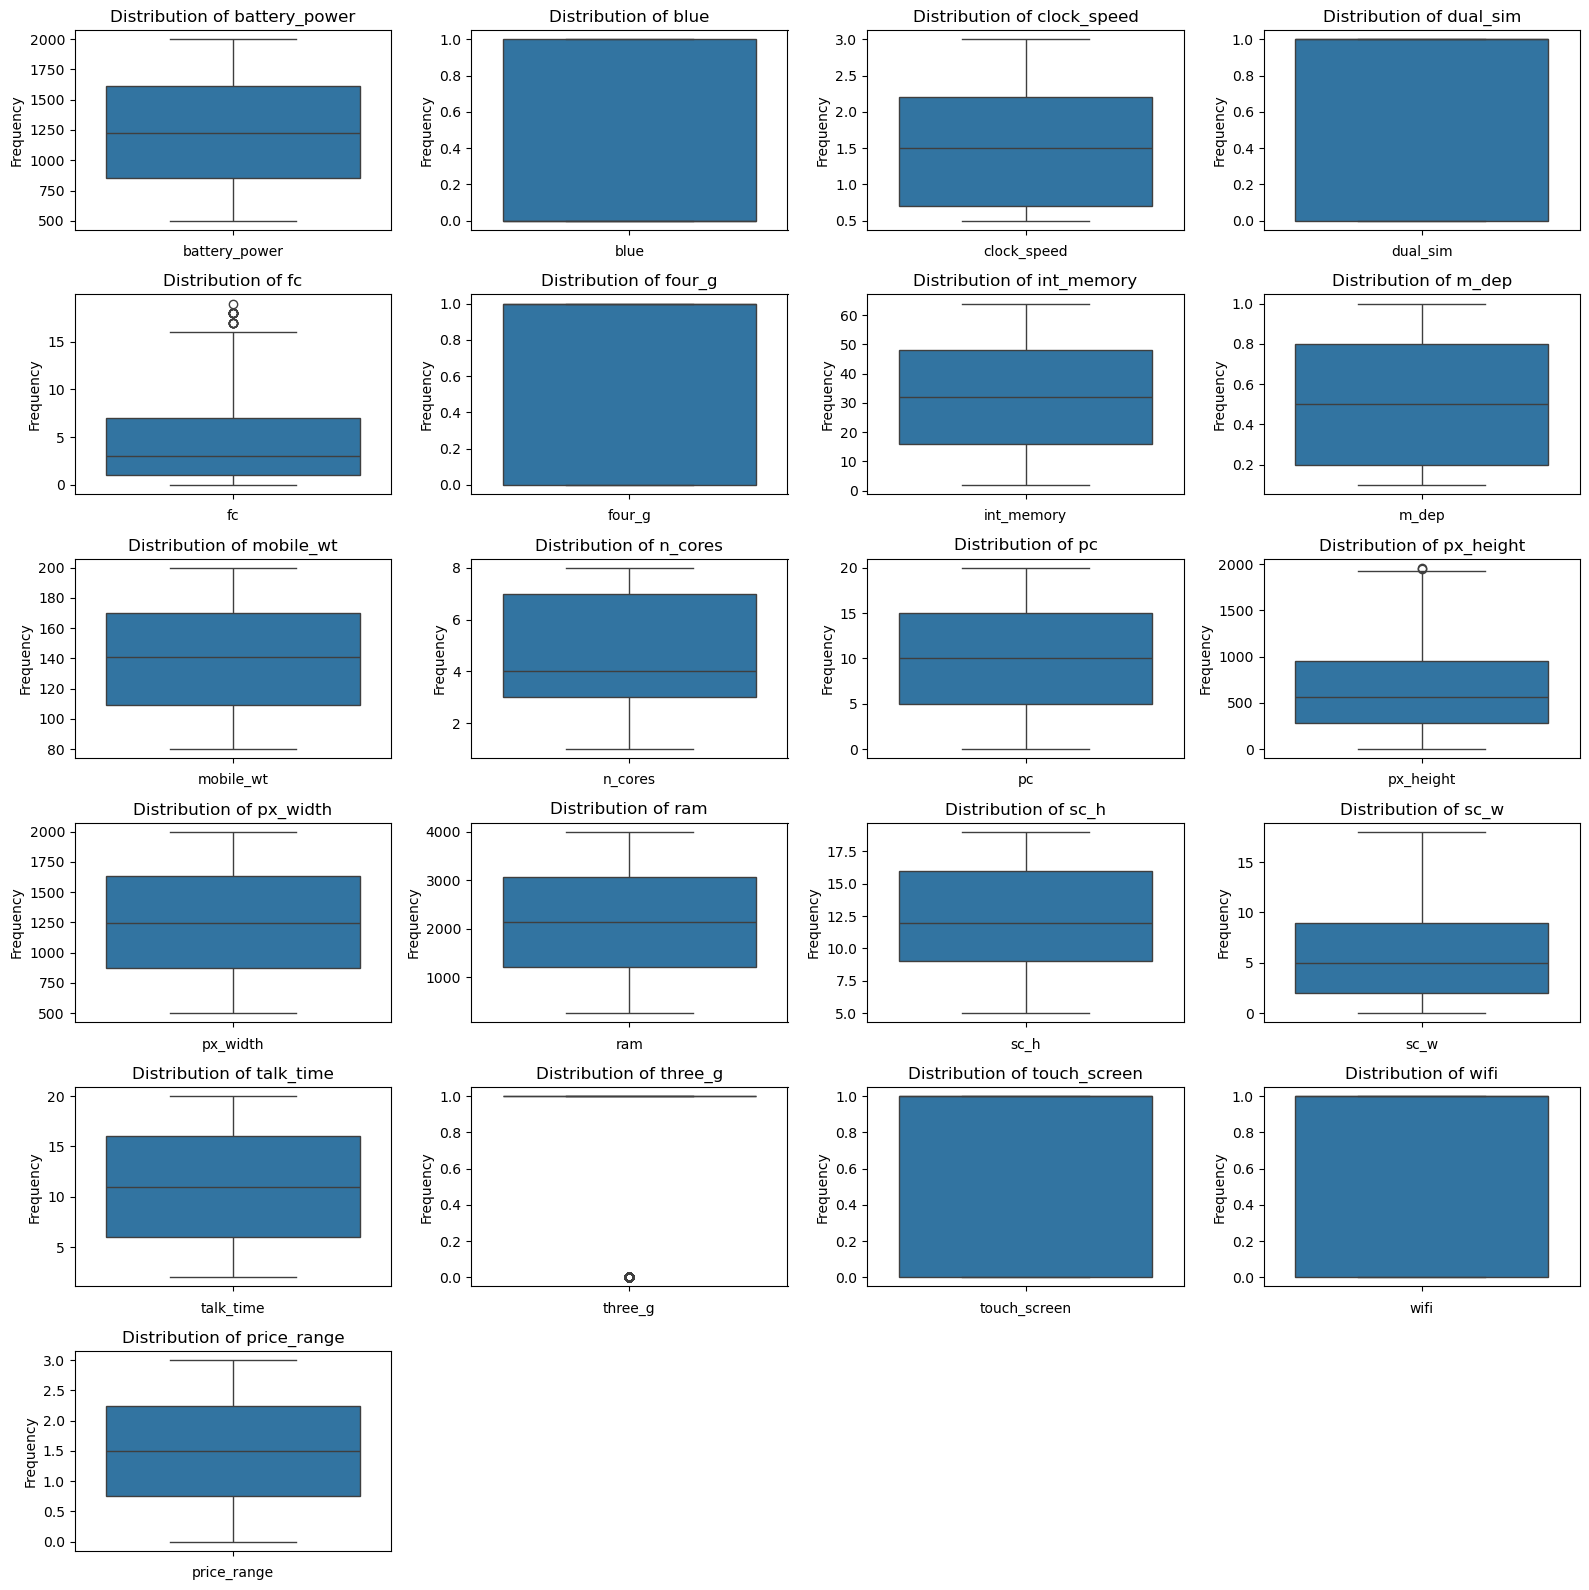

In [70]:
rows = len(df.columns)
dims = (rows+3)//4
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df.columns):
  plt.subplot(dims, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Create Pipeline 

In [78]:
def create_pipeline(model):
  
  steps = [
    ("scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("model", model)
  ]
  
  return Pipeline(steps=steps)

In [47]:
X, y = df.drop("price_range", axis=1), df["price_range"]

# PCA Analysis

In [80]:
features = range(1, X.shape[1]+1)
metric_tracker = []
for n_component in features:
  pca = PCA(n_components=n_component)
  pipeline = create_pipeline(pca)
  X_pca = pipeline.fit_transform(X)
  
  cum_var = np.sum(pca.explained_variance_ratio_)
  metric_tracker.append({
    "Model":"PCA",
    "N":n_component,
    "Cum-Var": cum_var
  })

pca_analysis_df = pd.DataFrame(metric_tracker)
print(pca_analysis_df)

   Model   N   Cum-Var
0    PCA   1  0.084638
1    PCA   2  0.165142
2    PCA   3  0.242492
3    PCA   4  0.313341
4    PCA   5  0.369370
5    PCA   6  0.423634
6    PCA   7  0.476196
7    PCA   8  0.528197
8    PCA   9  0.578965
9    PCA  10  0.629273
10   PCA  11  0.678343
11   PCA  12  0.727050
12   PCA  13  0.774719
13   PCA  14  0.822325
14   PCA  15  0.867062
15   PCA  16  0.910859
16   PCA  17  0.937552
17   PCA  18  0.962742
18   PCA  19  0.983362
19   PCA  20  1.000000


# 70-90% of the variance is between 12-20 columns

In [ ]:
def evaluate_model(model, X, y, scoring_metric):
  cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=42)
  scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_metric, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
  
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions, average="weighted")
  recall_metric = recall_score(y, predictions)
  precision_metric = precision_score(y, predictions)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(recall_metric,3),
    round(precision_metric,3)
  ]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=0)

In [49]:
X_train.to_csv("train-V1.csv", index=False)
X_test.to_csv("test-V1.csv", index=False)

In [50]:
train_path = sess.upload_data(
  path="train-V1.csv", bucket=BUCKET_NAME, key_prefix=SK_PREFIX_TRAIN
)

In [53]:
test_path = sess.upload_data(
  path="test-V1.csv", bucket=BUCKET_NAME, key_prefix=SK_PREFIX_TEST
)